# Predicting Fuel Effieciency 

This notebook implements linear regression and dense neural network (DNN) regression with Tensorflow to predict fuel effiency. The variable to predict is MPG

The dataset can be found here: 
http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data

This notebook follows the tutorial from the Tensorflow website:
https://www.tensorflow.org/tutorials/keras/regression

In [2]:
import numpy      as np
import pandas     as pd
import tensorflow as tf
import seaborn    as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow       import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

np.set_printoptions(precision=3, suppress=True)

In [3]:
# Download data directly from UCI archive and convert to pandas dataframe
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

# Drop rows which have null entries
dataset = raw_dataset.dropna()

In [3]:
# Perform 70/30 train test split and separate features and labels

train_data = dataset.sample(frac=0.7,random_state=1)
test_data  = dataset.drop(train_data.index)

train_feats = dataset.drop('MPG',axis=1)
train_labels = dataset['MPG']

test_feats = dataset.drop('MPG',axis=1)
test_labels = dataset['MPG']

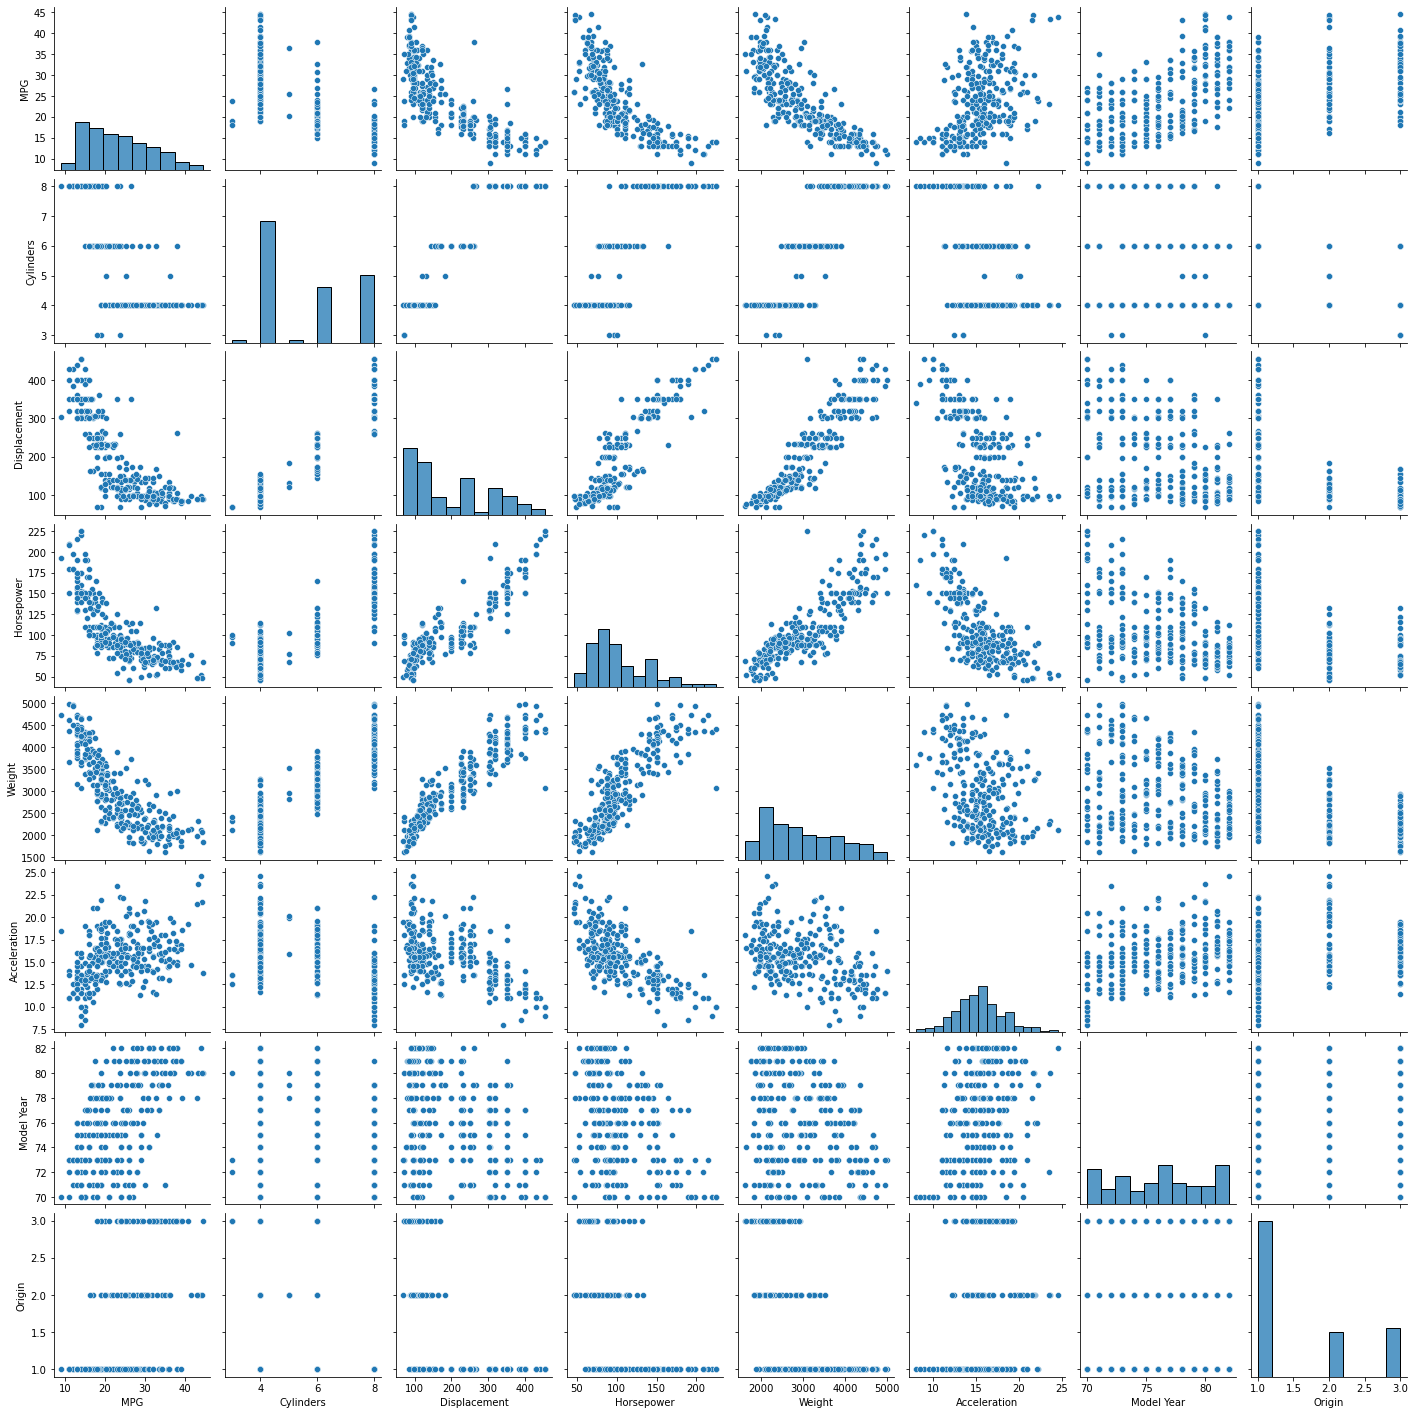

In [4]:
# Make pair plots of data using Seaborn
sns.pairplot(train_data,diag_kind='hist')

## Create Linear Regression Model

In [5]:
# plotting function to plot losses
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch',fontsize=13)
    plt.ylabel('Error',fontsize=13)
#     plt.yscale('log')
    plt.xlim(0,1000)
    plt.legend()
    plt.grid(True)
    plt.show()

In [6]:
# Use normalizer to independently normalize each feature
normalizer = preprocessing.Normalization(axis=-1)
norm_train_feats = normalizer.adapt(np.array(train_feats))

In [7]:
# Create Linear Model
linear_model = tf.keras.Sequential([normalizer,layers.Dense(units=1)])

In [8]:
# Configure the model by choosing optimizer and loss function
linear_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
                     loss='mean_absolute_error')

In [9]:
# Train model (Use 20% of training data for validation)
history = linear_model.fit(train_feats,train_labels,epochs=1000,verbose=0,validation_split = 0.2)

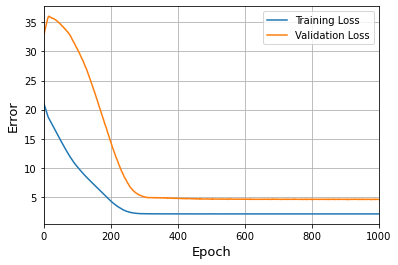

In [10]:
# Plot losses using our plotting function
plot_loss(history)

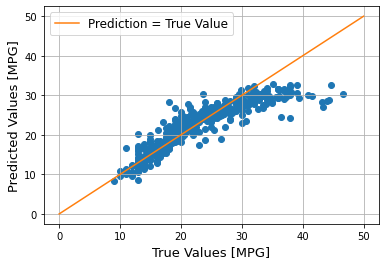

In [11]:
# Plotting function for predictions vs true values
def plot_preds(preds,true):
    x = np.linspace(0,50,10)
    
    plt.scatter(true,preds)
    plt.plot(x,x,c='C1',label='Prediction = True Value')
    plt.xlabel('True Values [MPG]',fontsize=13)
    plt.ylabel('Predicted Values [MPG]',fontsize=13)
    plt.grid('Both')
    plt.legend(fontsize=12)
    plt.show()
    
# Make predictions based on the linear model
linear_preds = linear_model.predict(test_feats).flatten()
plot_preds(linear_preds,test_labels)

Our linear model performs reasonably well at predicting the true values but there is a slight bias at larger MPG values which we were not able to predict. Now we try a DNN regressor and see if we can improve.

# DNN Regressor

In [12]:
# DNN regressor will use similar code with some slight modifications to 
# add additional non-linear layers to our model with ReLu activation

dnn_model = tf.keras.Sequential([normalizer,layers.Dense(10,activation='relu'),
                                layers.Dense(10,activation='relu'),
                                layers.Dense(10,activation='relu'),
                                layers.Dense(1)])

In [13]:
# Compile the model with the optimizer and loss function same as before
dnn_model.compile(loss='mean_absolute_error',
                  optimizer=tf.keras.optimizers.Adam(0.001))

In [14]:
# Train the model
history = dnn_model.fit(train_feats,train_labels,epochs=1000,verbose=0,validation_split = 0.2)

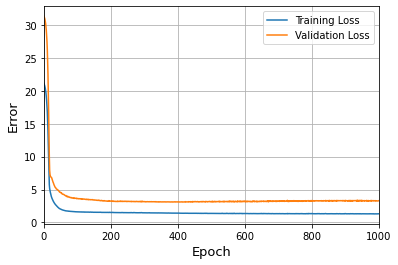

In [15]:
# Plot losses
plot_loss(history)

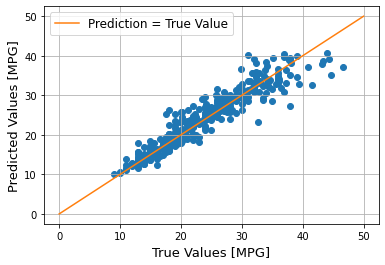

In [16]:
# Make predictions
dnn_preds = dnn_model.predict(test_feats).flatten()
plot_preds(dnn_preds,test_labels)

We can see that the DNN model does not have the same bias at large MPG values
that was seen in the linear model. We also notice that the losses on both the training
and validation sets is lower than the linear model.

Below we show the mean absolute error of both of our models and we see 
that the DNN model performed better than the linear model as expected.

In [18]:
# Make dictionary of results to compare linear and DNN models
test_results = {}
test_results['DNN'] = dnn_model.evaluate(test_feats, test_labels,verbose=0)
test_results['Linear'] = linear_model.evaluate(test_feats, test_labels,verbose=0)
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
DNN,1.686056
Linear,2.578990
